# 2030 데이터로 Word2Vector사용하기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = 10,5
plt.rcParams['axes.unicode_minus'] = False

In [3]:
import os
os.getcwd()

'c:\\Users\\master4\\Documents\\eunseo\\05. TEAM PROJECT\\FinalProject\\4.7보궐선거_분석\\word2vector'

In [4]:
df = pd.read_csv('../2030표심 및 정치성향 분석/data/전처리데이터/data2030_전처리_좋아요가중치_텍스트전처리.csv')
df.head()

,Title,Date,ID,Comment,Comment_date,Channel,Like,Dislike,Comment_like,Weighted_comment,Comment_textPreprocessing
0,#139​ 민주당 지도부가 2030 마음을 얻으려면...,2021-04-08,샤인디케이,"내리막이 있으면 다시 오르막이 있는 법, 예방주사라 생각하고 힘들 냅시다.",2021-04-10,박시영TV,6400.0,83.0,48.0,"['내리막이 있으면 다시 오르막이 있는 법, 예방주사라 생각하고 힘들 냅시다.', ...","내리막이 있으면 다시 오르막이 있는 법, 예방주사라 생각하고 힘들 냅시다."
1,#139​ 민주당 지도부가 2030 마음을 얻으려면...,2021-04-08,문동렬,2030마음을 얻으려면 조언을 2030을 모셔다가 들어보는 성의를 보여야 됩니다. ...,2021-04-10,박시영TV,6400.0,83.0,37.0,['2030마음을 얻으려면 조언을 2030을 모셔다가 들어보는 성의를 보여야 됩니다...,2030 마음을 얻으려면 조언을 2030을 모셔다가 들어보는 성의를 보여야 합니다....
2,#139​ 민주당 지도부가 2030 마음을 얻으려면...,2021-04-08,135 swan,전 군대 전역 전까지는 보수를 지지했지만 대학에서 양극화에 관심을 가지면서 진보로 ...,2021-04-10,박시영TV,6400.0,83.0,34.0,['전 군대 전역 전까지는 보수를 지지했지만 대학에서 양극화에 관심을 가지면서 진보...,"전 군대 전역 전까지는 보수를 지지했지만, 대학에서 양극화에 관심을 가지면서 진보로..."
3,#139​ 민주당 지도부가 2030 마음을 얻으려면...,2021-04-08,미루,몸 안에서 무엇인가 무너져 내린 기분..그래도 힘내고 가야죠민주당은 뼈아픈 진단 새...,2021-04-10,박시영TV,6400.0,83.0,67.0,['몸 안에서 무엇인가 무너져 내린 기분..그래도 힘내고 가야죠민주당은 뼈아픈 진단...,몸 안에서 무엇인가 무너져 내린 기분.. 그래도 힘내고 가야죠. 민주당은 뼈아픈 진...
4,#139​ 민주당 지도부가 2030 마음을 얻으려면...,2021-04-08,단아란,네 죄송합니다. 삭제하겠습니다,2021-04-10,박시영TV,6400.0,83.0,34.0,"['네 죄송합니다. 삭제하겠습니다', '네 죄송합니다. 삭제하겠습니다', '네 죄송...",네 죄송합니다. 삭제하겠습니다


In [5]:
# 데이터 구조 파악하기
df.shape

(56829, 11)

https://wikidocs.net/book/2155

# 1. Word2Vec
- 각 단어 벡터가 단어 간 유사도를 반영
- '비슷한 위치에서 등장하는 단어들은 비슷한 의미를 가진다'

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [7]:
df.columns

Index(['Title', 'Date', 'ID', 'Comment', 'Comment_date', 'Channel', 'Like',
       'Dislike', 'Comment_like', 'Weighted_comment',
       'Comment_textPreprocessing'],
      dtype='object')

In [56]:
df['Comment_textPreprocessing'].shape

(56829,)

In [57]:
# Null값 
df['Comment_textPreprocessing'].isnull().sum() # 댓글이 없는 문장도 있다. 

120

In [71]:
null_idx = df[df['Comment_textPreprocessing'].isnull()].index
# null값 제거하기
df2 = df.drop(  labels=null_idx, axis=0 )
# df2.head()
df2.shape # 120 rows 제거

(56709, 11)

### 1.1 한글 정규 표현식으로 한글 외 문자 제거

In [72]:
def text_clearing(text):
    # 한글 정규식
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    
    # 한글 외의 모든 문자를 길이가 0인 문자열로 변형
    result = hangul.sub('', text)
    
    return result

In [74]:
# 텍스트 전처리를 마친 상태임으로 전처리를 다시 하지 않음. 
df2['Comment_textPreprocessing'] = df2['Comment_textPreprocessing'].apply( lambda x: text_clearing(x))

In [75]:
# 불용어 정의

with open ('../2030표심 및 정치성향 분석/data/불용어/politics_stopwords_nouns.txt', 'rt',encoding='utf-8') as fp:
    stopwords = fp.readlines()
stopwords = [i.replace('\n','') for i in stopwords]



In [51]:
df['Comment_textPreprocessing']

0                내리막이 있으면 다시 오르막이 있는 법, 예방주사라 생각하고 힘들 냅시다.
1        2030 마음을 얻으려면 조언을 2030을 모셔다가 들어보는 성의를 보여야 합니다....
2        전 군대 전역 전까지는 보수를 지지했지만, 대학에서 양극화에 관심을 가지면서 진보로...
3        몸 안에서 무엇인가 무너져 내린 기분.. 그래도 힘내고 가야죠. 민주당은 뼈아픈 진...
4                                         네 죄송합니다. 삭제하겠습니다
                               ...                        
56824             간교한 인간성을 가진, 김종인, 안 띨 수를 섬기느니.. 죽는 게 낫다.
56825            이준석 정치 연륜이 뭐가 있다고 이렇게 나와서 이야기를 많이 하고 다니나?
56826    준석아 주둥이 조심해라. 안철수가 할 말이 옳다. 단일화 못 했으면 오세훈 승리 없...
56827                                            김준석 아웃 밉상
56828                    토론자가 없어서 양문석, 이준석을 부르냐??? 한심하네!!!
Name: Comment_textPreprocessing, Length: 56829, dtype: object

In [76]:
# 형태소 정의
okt = Okt()
tokenized_data = []
for sentence in df2['Comment_textPreprocessing']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

제목+댓글내용의 최대 길이 : 1129
제목+댓글내용의 평균 길이 : 20.85566664903278


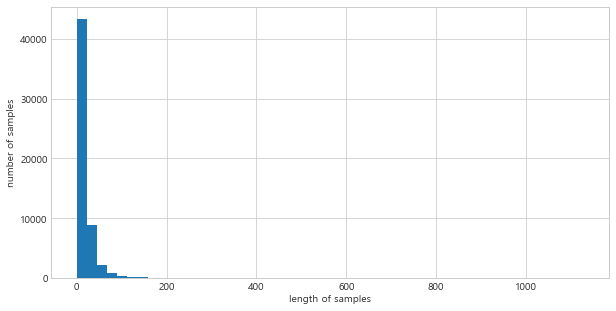

In [77]:
# 제목+댓글내용 길이 분포 확인
print('제목+댓글내용의 최대 길이 :',max(len(l) for l in tokenized_data))
print('제목+댓글내용의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 1.2  Word2Vec 훈련시키기
- (없음)size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
- window = 컨텍스트 윈도우 크기
- min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
- workers = 학습을 위한 프로세스 수
- sg = 단어벡터 계산방법. 0은 CBOW, 1은 Skip-gram.

In [173]:
from gensim.models import Word2Vec
# Word2Vec 모델 생성
model = Word2Vec(sentences = tokenized_data, window = 5, min_count = 5, workers = 4, sg = 1)

In [174]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(10664, 100)

## 단어 벡터간 덧셈, 뺄셈 가능
- King + woman - man = Queen

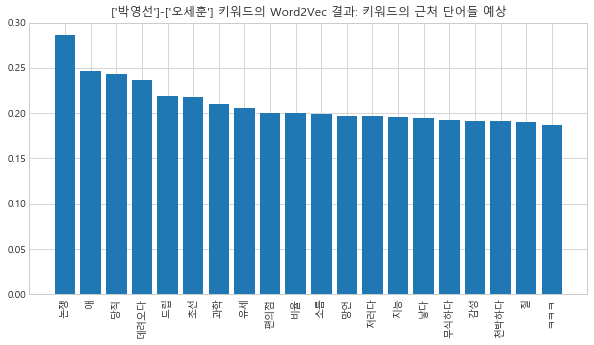

In [175]:
keywords = ['박영선']
negative_words = ['오세훈']
result = np.array(model.wv.most_similar( positive=keywords, negative=negative_words , topn=20))
tmp = [float(i) for i in result[:,1] ]
plt.bar( result[:,0], tmp )
plt.xticks(rotation=90)
plt.title(f'{keywords}-{negative_words} 키워드의 Word2Vec 결과: 키워드의 근처 단어들 예상')
plt.show()

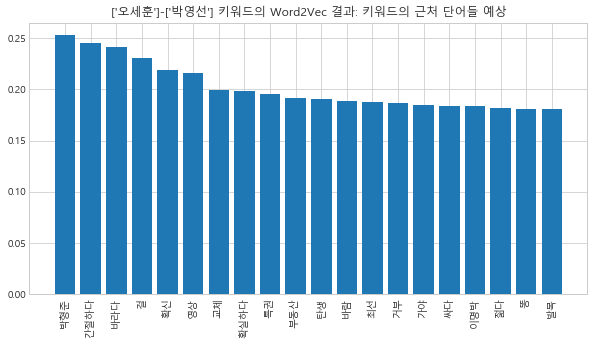

In [176]:
keywords = ['오세훈']
negative_words = ['박영선']
result = np.array(model.wv.most_similar( positive=keywords, negative=negative_words , topn=20))
tmp = [float(i) for i in result[:,1] ]
plt.bar( result[:,0], tmp )
plt.xticks(rotation=90)
plt.title(f'{keywords}-{negative_words} 키워드의 Word2Vec 결과: 키워드의 근처 단어들 예상')
plt.show()

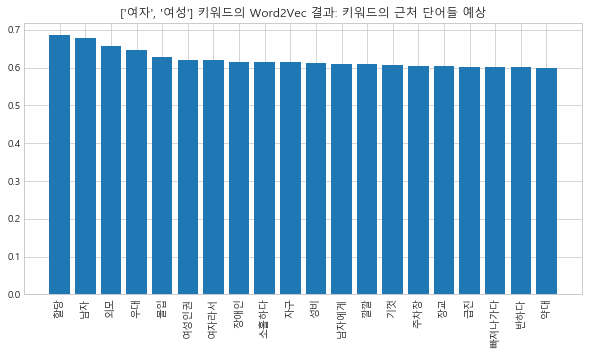

In [192]:
keywords = ['여자','여성']
result = np.array(model.wv.most_similar( positive=keywords , topn=20))
tmp = [float(i) for i in result[:,1] ]
plt.bar( result[:,0], tmp )
plt.xticks(rotation=90)
plt.title(f'{keywords} 키워드의 Word2Vec 결과: 키워드의 근처 단어들 예상')
plt.show()

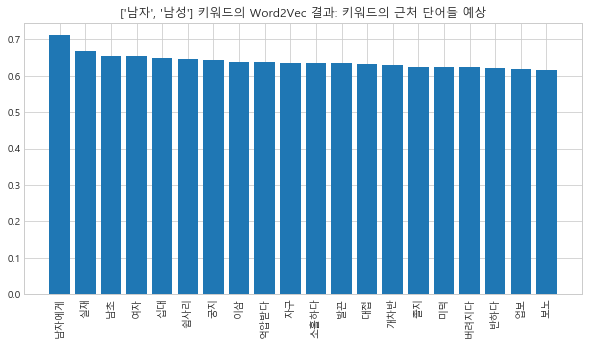

In [180]:
keywords = ['남자','남성']
result = np.array(model.wv.most_similar( positive=keywords , topn=20))
tmp = [float(i) for i in result[:,1] ]
plt.bar( result[:,0], tmp )
plt.xticks(rotation=90)
plt.title(f'{keywords} 키워드의 Word2Vec 결과: 키워드의 근처 단어들 예상')
plt.show()

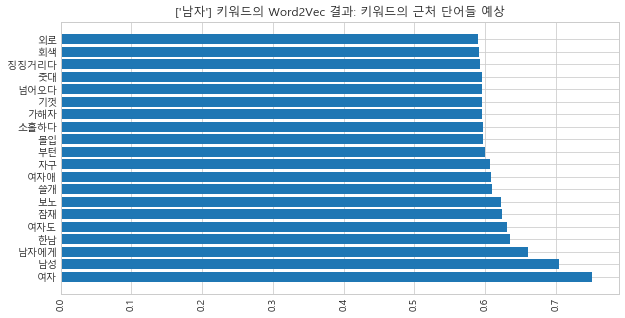

In [190]:
keywords = ['남자']
negative_words = None
result = np.array(model.wv.most_similar( positive=keywords, negative=negative_words, topn=20))
tmp = [float(i) for i in result[:,1] ]
plt.barh( result[:,0], tmp )
plt.xticks(rotation=90)
plt.title(f'{keywords} 키워드의 Word2Vec 결과: 키워드의 근처 단어들 예상')
plt.show()

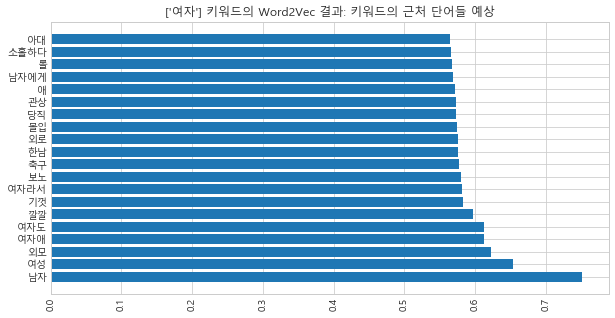

In [189]:
keywords = ['여자']
negative_words = None
result = np.array(model.wv.most_similar( positive=keywords, negative=negative_words, topn=20))
tmp = [float(i) for i in result[:,1] ]
plt.barh( result[:,0], tmp )
plt.xticks(rotation=90)
plt.title(f'{keywords} 키워드의 Word2Vec 결과: 키워드의 근처 단어들 예상')
plt.show()

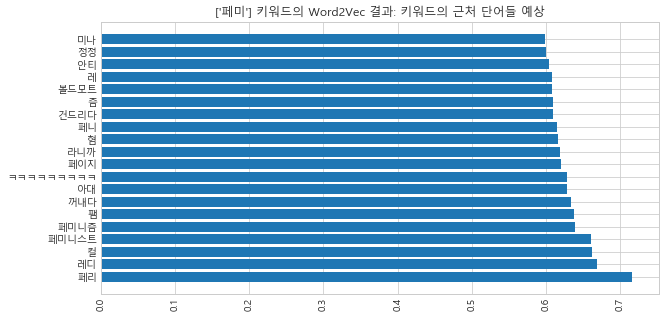

In [197]:
keywords = ['페미']
result = np.array(model.wv.most_similar( positive=keywords , topn=20))
tmp = [float(i) for i in result[:,1] ]
plt.barh( result[:,0], tmp )
plt.xticks(rotation=90)
plt.title(f'{keywords} 키워드의 Word2Vec 결과: 키워드의 근처 단어들 예상')
plt.show()

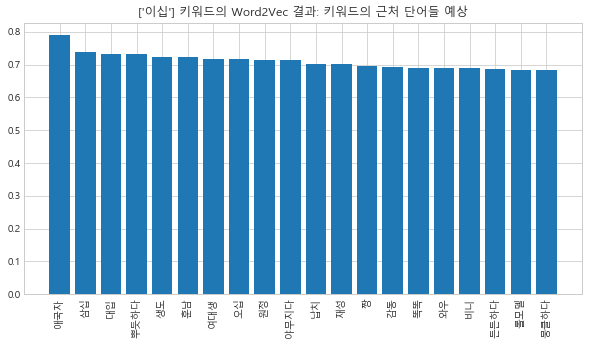

In [198]:
keywords = ['이십']
result = np.array(model.wv.most_similar( positive=keywords , topn=20))
tmp = [float(i) for i in result[:,1] ]
plt.bar( result[:,0], tmp )
plt.xticks(rotation=90)
plt.title(f'{keywords} 키워드의 Word2Vec 결과: 키워드의 근처 단어들 예상')
plt.show()

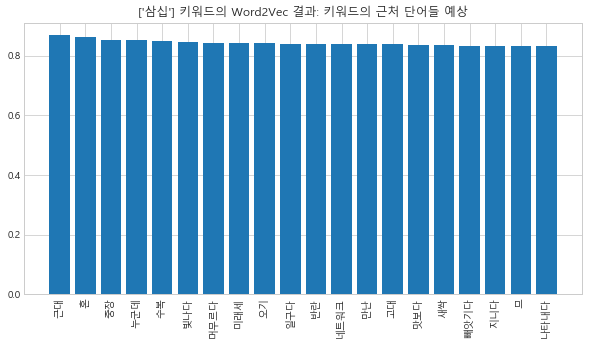

In [165]:
keywords = ['삼십']
result = np.array(model.wv.most_similar( positive=keywords , topn=20))
tmp = [float(i) for i in result[:,1] ]
plt.bar( result[:,0], tmp )
plt.xticks(rotation=90)
plt.title(f'{keywords} 키워드의 Word2Vec 결과: 키워드의 근처 단어들 예상')
plt.show()

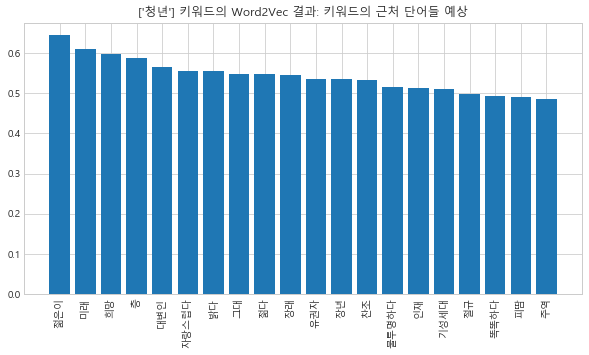

In [155]:
keywords = ['청년']
result = np.array(model.wv.most_similar( positive=keywords , topn=20))
tmp = [float(i) for i in result[:,1] ]
plt.bar( result[:,0], tmp )
plt.xticks(rotation=90)
plt.title(f'{keywords} 키워드의 Word2Vec 결과: 키워드의 근처 단어들 예상')
plt.show()

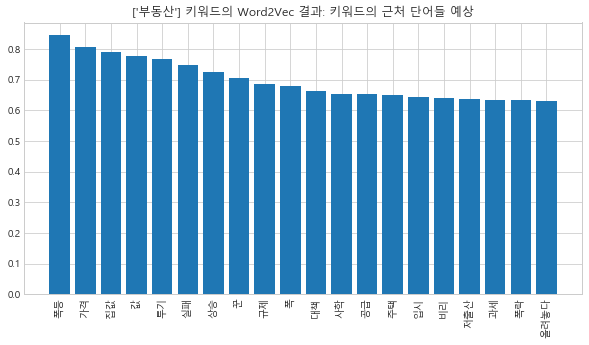

In [156]:
keywords = ['부동산']
result = np.array(model.wv.most_similar( positive=keywords , topn=20))
tmp = [float(i) for i in result[:,1] ]
plt.bar( result[:,0], tmp )
plt.xticks(rotation=90)
plt.title(f'{keywords} 키워드의 Word2Vec 결과: 키워드의 근처 단어들 예상')
plt.show()

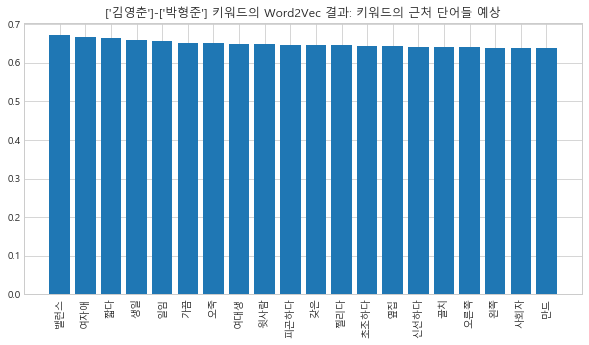

In [158]:
keywords = ['김영춘']
negative_words = ['박형준']
result = np.array(model.wv.most_similar( positive=keywords, negative=negative_words , topn=20))
tmp = [float(i) for i in result[:,1] ]
plt.bar( result[:,0], tmp )
plt.xticks(rotation=90)
plt.title(f'{keywords}-{negative_words} 키워드의 Word2Vec 결과: 키워드의 근처 단어들 예상')
plt.show()

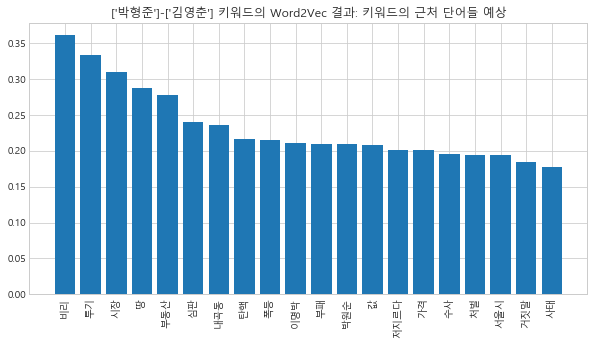

In [160]:
keywords = ['박형준']
negative_words = ['김영춘']
result = np.array(model.wv.most_similar( positive=keywords, negative=negative_words , topn=20))
tmp = [float(i) for i in result[:,1] ]
plt.bar( result[:,0], tmp )
plt.xticks(rotation=90)
plt.title(f'{keywords}-{negative_words} 키워드의 Word2Vec 결과: 키워드의 근처 단어들 예상')
plt.show()

In [124]:
print(model.wv.most_similar("박영선"))

[('오세훈', 0.7561795711517334), ('후보', 0.7262828946113586), ('서울시장', 0.7188799381256104), ('캠프', 0.6751555800437927), ('안철수', 0.6586655974388123), ('부산시', 0.656805694103241), ('시장', 0.6495846509933472), ('박원순', 0.6471335887908936), ('거짓말쟁이', 0.6462576389312744), ('예비', 0.6424965858459473)]


In [23]:
print(model.wv.most_similar("오세훈"))

[('세훈', 0.5848418474197388), ('박영선', 0.5764411687850952), ('초조하다', 0.4346209764480591), ('김영춘', 0.43386954069137573), ('금태섭', 0.4278375506401062), ('유선', 0.4111238718032837), ('내곡동', 0.40984031558036804), ('불꽃', 0.4010070264339447), ('오', 0.3994719684123993), ('유력하다', 0.399166077375412)]


In [24]:
print(model.wv.most_similar("김영춘"))

[('이언주', 0.5599566102027893), ('박형준', 0.5590013861656189), ('대박', 0.5197573304176331), ('정규재', 0.5175073742866516), ('해운대', 0.5071338415145874), ('올인', 0.4768833816051483), ('부산', 0.4567868411540985), ('조강지처', 0.44635123014450073), ('바다이야기', 0.43766355514526367), ('이진복', 0.43741574883461)]


In [25]:
print(model.wv.most_similar("박형준"))

[('김영춘', 0.5590013265609741), ('자갈치', 0.4380435645580292), ('박영선', 0.4149247407913208), ('환조', 0.3987842798233032), ('엠비', 0.39268428087234497), ('무선전화', 0.3913780450820923), ('엘', 0.38856780529022217), ('은희', 0.38589486479759216), ('정규재', 0.38456737995147705), ('부인', 0.38181737065315247)]


### 1.3 모델 저장

In [26]:
from gensim.models import KeyedVectors
# 모델 저장
model.wv.save_word2vec_format('model/word2vec/w2v_TitleComments_0427')

In [1]:
 # 모델 로드
from gensim.models import KeyedVectors
loaded_model = KeyedVectors.load_word2vec_format("./w2v_TitleComments_0427")

In [3]:
model_result = loaded_model.most_similar("민주당",topn=10)
print(model_result)

[('여당', 0.5833343267440796), ('지당', 0.505938708782196), ('정의당', 0.4959515929222107), ('만지다', 0.4899117350578308), ('민주', 0.47781601548194885), ('당', 0.42012691497802734), ('야당', 0.415071040391922), ('여권', 0.4129944443702698), ('보궐', 0.4082983136177063), ('더듬다', 0.40013939142227173)]


In [4]:
model_result = loaded_model.most_similar("국힘",topn=20)
print(model_result)

[('국짐', 0.8264971971511841), ('더민', 0.7123269438743591), ('구김', 0.6722763180732727), ('불민', 0.6586393713951111), ('국집', 0.6302757859230042), ('당대', 0.6089860200881958), ('더추', 0.5967254638671875), ('힘', 0.5951818823814392), ('더듬이', 0.5773580074310303), ('더블', 0.5682083964347839), ('정청', 0.5678206086158752), ('보수당', 0.5645935535430908), ('짐', 0.5555760860443115), ('덜민', 0.543167769908905), ('국똥', 0.5397177934646606), ('지지자', 0.5289016962051392), ('다수', 0.5119171738624573), ('창', 0.5115551948547363), ('홍준표', 0.49535682797431946), ('신돈', 0.4913056492805481)]


In [5]:
loaded_model.most_similar("오세훈",topn=20)

[('세훈', 0.5848418474197388),
 ('박영선', 0.5764411687850952),
 ('초조하다', 0.4346209764480591),
 ('김영춘', 0.43386954069137573),
 ('금태섭', 0.4278375506401062),
 ('유선', 0.4111238718032837),
 ('내곡동', 0.40984031558036804),
 ('불꽃', 0.4010070264339447),
 ('오', 0.3994719684123993),
 ('유력하다', 0.399166077375412),
 ('우위', 0.39101722836494446),
 ('적합', 0.3858765661716461),
 ('상대', 0.38381409645080566),
 ('김진애', 0.3830387592315674),
 ('토론', 0.3821444511413574),
 ('나경원', 0.36653217673301697),
 ('세후니', 0.36534902453422546),
 ('도사', 0.3632289171218872),
 ('영선', 0.3608013689517975),
 ('대결', 0.35436075925827026)]

### 1.4 단어간 거리 확인
- 코사인 유사도를 이용한 단어간 거리 확인

In [6]:
loaded_model.distance('오세훈', '화이팅')

0.8531581610441208

In [7]:
loaded_model.distance('박영선', '화이팅')

0.7453278601169586

In [8]:
loaded_model.distance('오세훈', '망하다')

1.074504368007183

In [9]:
loaded_model.distance('박영선', '망하다')

1.0924549922347069

# Permission denied:
파일 경로가 이상하거나 파일이 아닌 폴더 경로 등을 지정할 경우 오류가 발생한다. 

출처: https://yjs-program.tistory.com/115 [Y초보프로그래머]